# KS ANALYSIS FOR MIT5K EXPERTC


The effect of the image enhancement operator is computed using this function: 

\begin{equation}
L_{\mathrm{out}} = \frac{L_{\mathrm{in}}^{\gamma}}{L_{\mathrm{in}}^{\gamma} + \mu^{\gamma}} 
\end{equation}

See paper for more details

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2

In [2]:
def cluster_names(df,
                  column_names,
                  red_column_names,
                  name_thr=0.8,
                  add_names_column=True):
    
    df_labels = list(set(df["labels"].values))
    
    cluster_names = []
    cluster_counts = []
    
    for label in df_labels:
        df_cluster = df[df["labels"]==label]
        
        df_cluster_counts = df_cluster[column_names].sum().values / len(df_cluster)
        df_cluster_counts = np.where(df_cluster_counts <= name_thr, df_cluster_counts, 1.0)
        df_cluster_counts = np.where(df_cluster_counts > name_thr, df_cluster_counts, 0.0)
        
        clust_name = ""
        for j, count in enumerate(df_cluster_counts):   
            if count == 1:
                clust_name += red_column_names[j] 
        
        cluster_names.append(clust_name)
        cluster_counts.append(df_cluster_counts)
        
      
    cluster_names =  cluster_names[:-1] + ["UN"]

    if add_names_column:
        map_label_names = {}
        
        for j, c_name in enumerate(cluster_names):
            if j == len(cluster_names)-1:
                j = -1
            map_label_names[j] = c_name
        
        df["label_name"] = df["labels"].map(map_label_names)

    return cluster_names, cluster_counts

In [3]:
def assign_luminosity_level(df):
    df["luminosity"] = ["0low lum"]*len(df)
    df.loc[df["avg lum"] == 1 , "luminosity"] = "1avg lum"
    df.loc[df["high lum"] == 1 , "luminosity"] = "2high lum"
    return None

In [4]:
def plot_parameter_distribution_per_luminosity(df, param="a", n_bins=50,save_path='',title_save=''):
    df = df[df["b"] < 1e10]
    df = df[df["a"] < 1e10]
    RD_a_low = df[df["luminosity"]=="0low lum"][param].values
    RD_a_avg = df[df["luminosity"]=="1avg lum"][param].values
    RD_a_high = df[df["luminosity"]=="2high lum"][param].values
    
    plt.hist(RD_a_low, n_bins, weights=np.ones(len(RD_a_low)) / len(RD_a_low), color="r", label="low",alpha=0.3)
    plt.hist(RD_a_avg, n_bins, weights=np.ones(len(RD_a_avg)) / len(RD_a_avg), color="b", label="avg",alpha=0.3)
    plt.hist(RD_a_high, n_bins, weights=np.ones(len(RD_a_high)) / len(RD_a_high), color="g", label="low",alpha=0.3)
    
    plt.legend()
    if title_save == '':
        if param == "a":
            title = r"$\gamma$"
        elif param == "b":
            title = r"$\mu$"
        else:
            title = param
    else:
        title = title_save
    
    plt.title(title)
    if save_path !='':
        plt.savefig(save_path)

In [5]:
def param_distr_per_feature(df, feature):
    
    features = list(set(df[feature].values))
    a_feature = []
    b_feature = []
    
    for j in features:
        a_feature.append(df[df[feature]==j]["a"].values)
        b_feature.append(df[df[feature]==j]["b"].values)

    return a_feature, b_feature

In [6]:
def ks_test(p_distributions, p_names, plot=True, alpha=0.05, title=None, cbar=False, save_path=''):
    
    p_values = []
    
    for i in range(len(p_distributions)):
        p_value_i = []
        for k in range(len(p_distributions)):
            p_value_ij = stats.ks_2samp(p_distributions[i], p_distributions[k])[1] <= alpha
            p_value_i.append(p_value_ij)
        p_values.append(p_value_i)
        
    if plot:
        mask = np.zeros_like(p_values)
        mask[np.triu_indices_from(mask)] = True
        
        colors = ["red", "green"] 
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
        
        ax = sns.heatmap(p_values, mask=mask, linewidth=0.5, xticklabels=p_names, yticklabels=p_names, cmap=cmap, vmin=0.0, vmax=1.0, cbar=cbar)

        if cbar == True:
            colorbar = ax.collections[0].colorbar
            colorbar.set_ticks([0.25,0.75])
            colorbar.set_ticklabels(['False', 'True'])
        
        ax.set_title(title)
        
        if save_path != '':
            plt.savefig(save_path)
            
    return p_values

In [7]:
def plot_a_b_per_group(df, group_name, q_low=0.40, q_high=0.60):
    
    median_fits_values = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile()
    median_fits_values_low = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile(q=q_low)
    median_fits_values_high = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile(q=q_high)
    
    for j in range(len(median_fits_values)):
        
        aerr = (median_fits_values_high.iloc[j]["a"] - median_fits_values_low.iloc[j]["a"])/2.
        berr = (median_fits_values_high.iloc[j]["b"] - median_fits_values_low.iloc[j]["b"])/2.0
        
        plt.errorbar(median_fits_values.iloc[j]["a"],
             median_fits_values.iloc[j]["b"],
             xerr=aerr,
             yerr=berr,
             fmt="o",
             label=median_fits_values.iloc[j][group_name])
        
    plt.xlabel(r"$\gamma$")
    plt.ylabel(r"$\mu$")
    plt.legend()
    plt.show()

In [8]:
clusters_df = pd.read_csv("../data/clusters/mit5k_big_input_train_labels.csv")

In [9]:
clusters_count = clusters_df[["image_name", "labels"]].groupby("labels", as_index=False).count()

In [10]:
clusters_count["perc"] = np.round(clusters_count["image_name"] / len(clusters_df),2)
clusters_count

,labels,image_name,perc
0,-1,52,0.07
1,0,172,0.23
2,1,106,0.14
3,2,100,0.13
4,3,101,0.13
5,4,136,0.18
6,5,83,0.11


In [11]:
cluster_names, cluster_counts  = cluster_names(clusters_df,
              ['low lum','avg lum','high lum','red','yellow','green','blue'],
              ["Da", "Av", "Br", "R", "Y", "G", "B"],
              add_names_column=True
             )

In [12]:
expertcTMO_df = pd.read_csv("../data/fit_luminance/mit5k_fits_expertc_non_linear1.csv")

In [13]:
expertcTMO_df = pd.merge(clusters_df, expertcTMO_df,  how="inner", on="image_idx")

(0.0, 0.201)

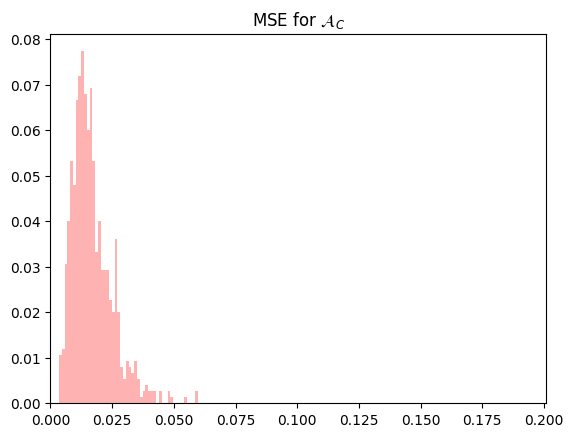

In [14]:
mses = expertcTMO_df["mse_err"].values

plt.hist(mses, 50, weights=np.ones(len(mses)) / len(mses), color="r",alpha=0.3)
plt.title(r"MSE for $\mathcal{A}_C$")
plt.xlim([0,0.201])

In [15]:
assign_luminosity_level(expertcTMO_df)

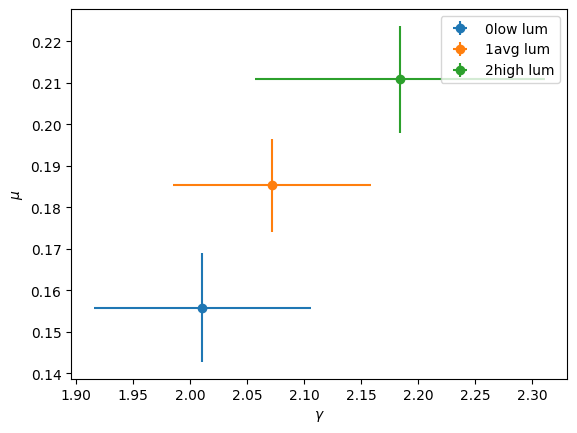

In [16]:
plot_a_b_per_group(expertcTMO_df, "luminosity")

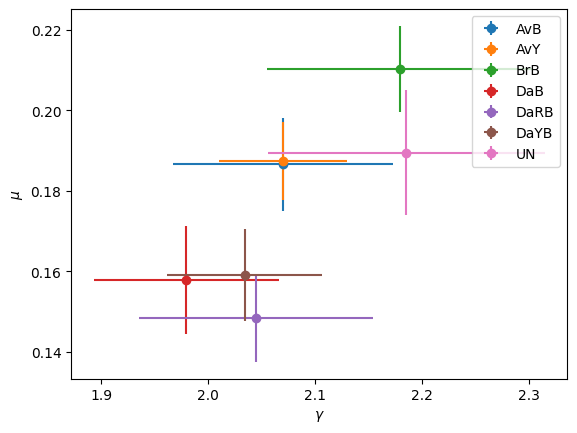

In [17]:
plot_a_b_per_group(expertcTMO_df, "label_name")

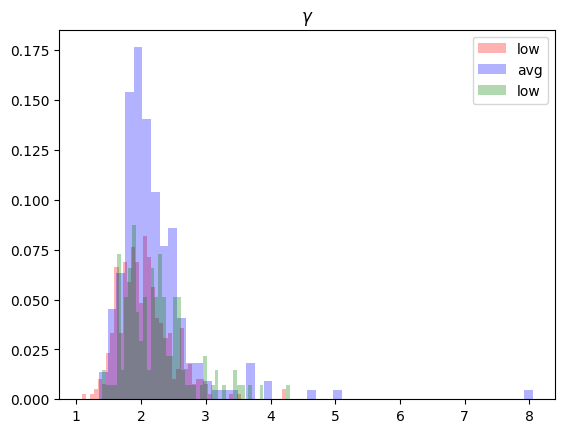

In [18]:
plot_parameter_distribution_per_luminosity(expertcTMO_df,"a")

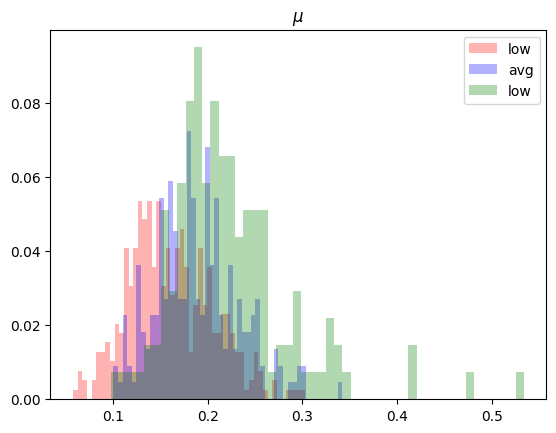

In [19]:
plot_parameter_distribution_per_luminosity(expertcTMO_df,"b")

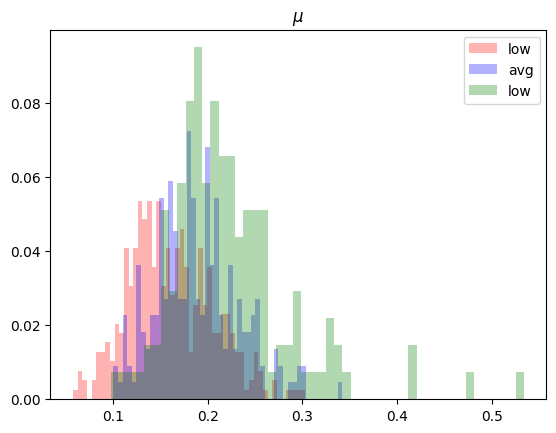

In [20]:
plot_parameter_distribution_per_luminosity(expertcTMO_df,"b")

In [21]:
[a_lum, b_lum] = param_distr_per_feature(expertcTMO_df, "luminosity")

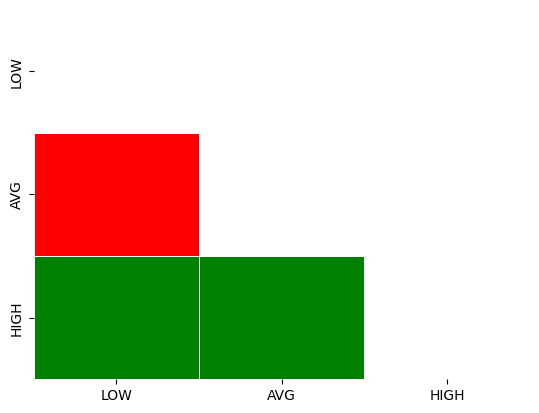

In [22]:
p_values_a_lum = ks_test(a_lum, ["LOW", "AVG", "HIGH"], plot=True, alpha=0.05)

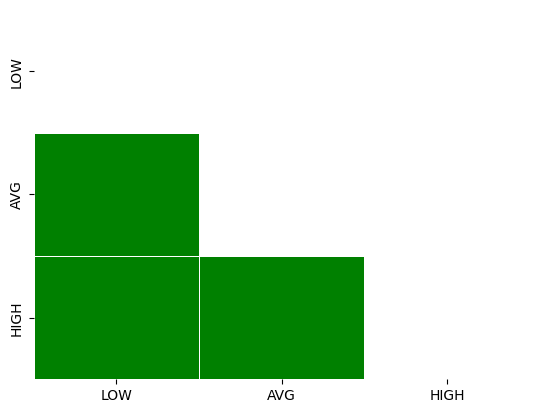

In [23]:
p_values_a_lum = ks_test(b_lum, ["LOW", "AVG", "HIGH"], plot=True, alpha=0.05)

REMINDER:
- **TRUE: p-values is smaller than 0.05**, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data were not drawn from the same distribution.
- **FALSE: p-values is higher than 0.05**, so we cannot reject the null hypothesis in favor of the default “two-sided” alternative: the data were drawn from the same distribution.

For Expert the groups with different **luminosity** are treated different since both $\mu$ is different from different luminosity.

In [24]:
expertcTMO_df = expertcTMO_df[expertcTMO_df["label_name"]!="UN"]

In [25]:
[a_cluster, b_cluster] = param_distr_per_feature(expertcTMO_df, "labels")

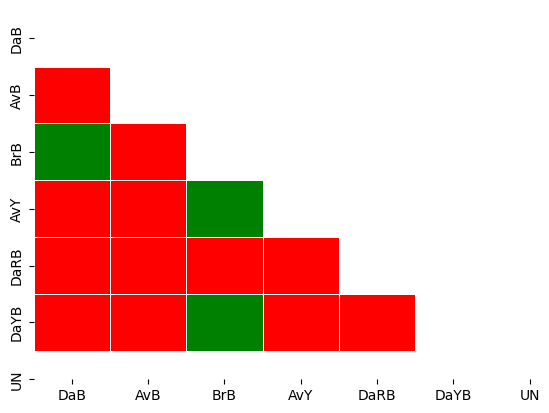

In [26]:
p_values_a_cluster = ks_test(a_cluster, cluster_names, plot=True, alpha=0.05)

ExpertC seems to apply a very similar $\gamma$ to almost each cluster. 

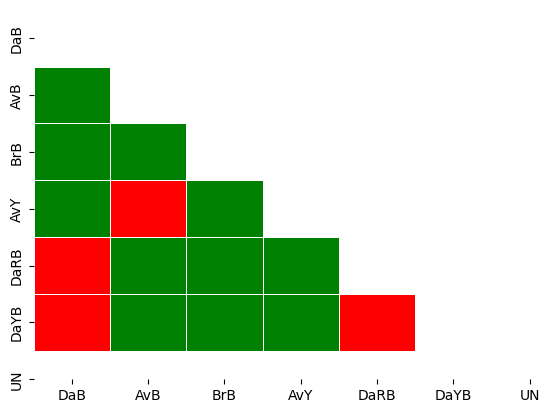

In [27]:
p_values_b_cluster = ks_test(b_cluster, cluster_names, plot=True, alpha=0.05)

ExpertC seems to apply a very similar $\mu$ to clusters with same luminosity but different $\mu$ if luminosity is different. 